# Машинное обучение

# Семинар 4

В данном ноутбуке мы изучим некоторые особенности поведения стохастического градиентного спуска, сравним его с (полным) градиентным спуском, покажем, насколько мощным инстументом для анализа данных может служить линейная регрессия, а также научимся запускать её в несколько строк кода.

## Градиентный спуск

Выпишем ещё раз явную формулу параметров линейной модели:

$$w = (X^TX)^{-1}X^Ty.$$

Здесь присутствует обращение матрицы $X^TX$ — очень трудоёмкая операция при большом количестве признаков. При решении задач такая трудоёмкость часто оказывается непозволительной, поэтому параметры ищут итерационными методами, стоимость которых меньше. Один из них — градиентный спуск.

Напомним, что в градиентном спуске значения параметров на следующем шаге получаются из значений параметров на текущем шаге смещением в сторону антиградиента функционала: 

$$w^{(t+1)} = w^{(t)} - \eta_t \nabla Q(w^{(t)}),$$
где $\eta_t$ — длина шага градиентного спуска.

Формула градиента функции ошибки в случае MSE выглядит следующим образом:

$$\nabla Q(w) = -2X^Ty + 2X^TXw = 2X^T(Xw - y).$$
 
Сложность вычислений в данном случае $O(dl)$. Стохастический градиентный спуск отличается от обычного заменой градиента на несмещённую оценку по одному или нескольким объектам. В этом случае сложность становится $O(kd)$, где $k$ — количество объектов, по которым оценивается градиент, $k << l$. Это отчасти объясняет популярность стохастических методов оптимизации.

### Визуализация траекторий GD и SGD
На простом примере разберём основные тонкости, связанные со стохастической оптимизацией.

In [1]:
%pylab inline
np.random.seed(16)
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


Сгенерируем матрицу объекты—признаки $X$ и вектор весов $w_{true}$, вектор целевых переменных $y$ высислим как $Xw_{true}$ и добавим нормальный шум:

In [2]:
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  # for different scales
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_0 = np.random.uniform(-2, 2, (n_features))

Обучим на полученных данных линейную регрессию для MSE при помощи полного градиентного спуска — тем самым получим вектор параметров.

In [3]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 1e-2

for i in range(num_steps):
    w -= 2 * step_size * np.dot(X.T, np.dot(X, w) - Y) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)

Покажем последовательность оценок параметров $w^{(t)}$, получаемых в ходе итераций. Красная точка — $w_{true}$.

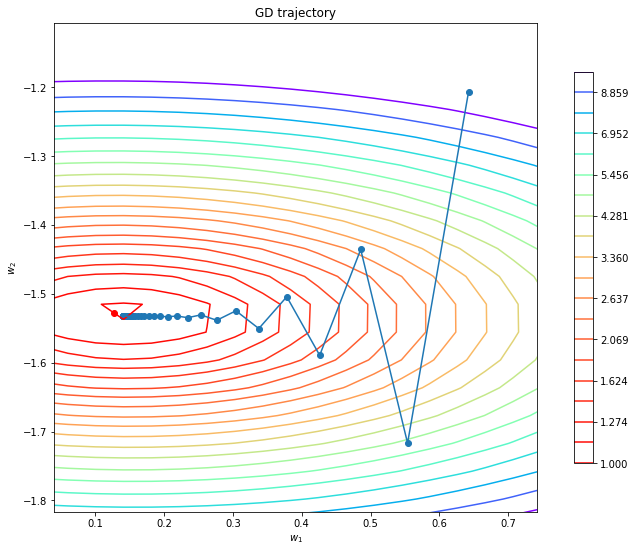

In [4]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(13, 9))
plt.title('GD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

Чуть ранее мы обсудили, что градиент перпендикулярен линиям уровня. Это объясняет такие зигзагообразные траектории градиентного спуска. Для большей наглядности в каждой точке пространства посчитаем градиент функционала и покажем его направление.

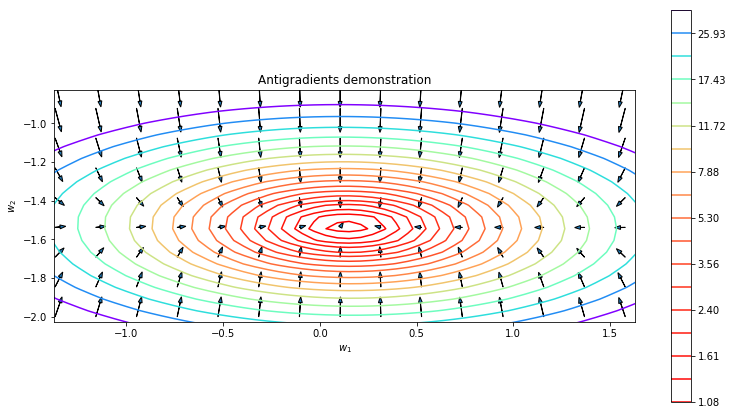

In [5]:
# compute level set
A, B = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
A_mini, B_mini = np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 27))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))
        
# visualize the level set
plt.figure(figsize=(13, 9))
CS = plt.contour(A, B, levels, levels=np.logspace(-1, 1.5, num=30), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
        
# visualize the gradients
gradients = np.empty_like(A_mini)
for i in range(A_mini.shape[0]):
    for j in range(A_mini.shape[1]):
        w_tmp = np.array([A_mini[i, j], B_mini[i, j]])
        antigrad = - 2*1e-3 * np.dot(X.T, np.dot(X, w_tmp) - Y) / Y.shape[0]
        plt.arrow(A_mini[i, j], B_mini[i, j], antigrad[0], antigrad[1], head_width=0.02)

plt.title('Antigradients demonstration')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_true[0] - 1.5, w_true[0] + 1.5))
plt.ylim((w_true[1] - .5, w_true[1] + .7))
plt.gca().set_aspect('equal')
plt.show()

Визуализируем теперь траектории стохастического градиентного спуска, повторив те же самые действия, оценивая при этом градиент по подвыборке.

In [8]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 0.1

for i in range(num_steps):
    sample = np.random.randint(n_objects, size=batch_size)
    w -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)

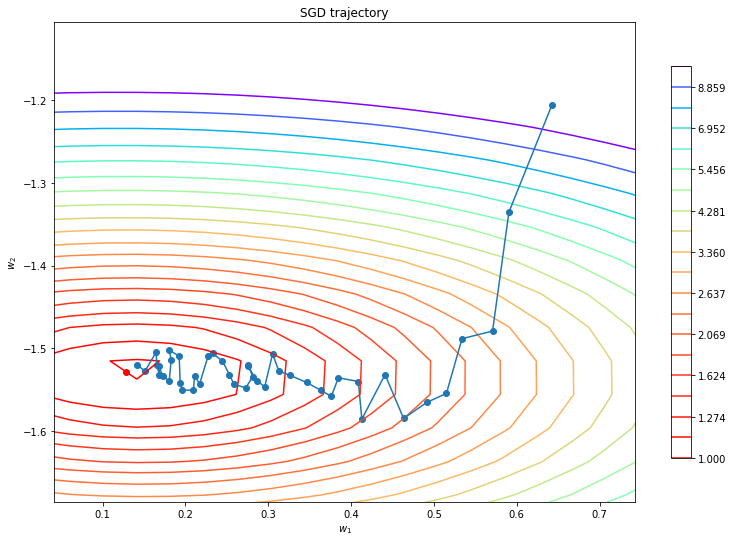

In [9]:
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(13, 9))
plt.title('SGD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1))
plt.ylim((w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

### Сравнение скоростей сходимости

Последнее, что хотелось бы продемонстрировать — сравнение, насколько быстро достигают оптимума метод полного и стохастического градиентного спуска. Сгенерируем выборку и построим график зависимости функционала от итерации.

In [10]:
# data generation
n_features = 50
n_objects = 1000
num_steps = 200
batch_size = 2

w_true = np.random.uniform(-2, 2, n_features)

X = np.random.uniform(-10, 10, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 5, n_objects)

In [17]:
step_size_sgd = 1.2
step_size_gd = 1e-2
w_sgd = np.random.uniform(-4, 4, n_features)
w_gd = w_sgd.copy()
residuals_sgd = [np.mean(np.power(np.dot(X, w_sgd) - Y, 2))]
residuals_gd = [np.mean(np.power(np.dot(X, w_gd) - Y, 2))]

for i in range(num_steps):
    step_size = step_size_sgd / ((i+1) ** 0.51)
    sample = np.random.randint(n_objects, size=batch_size)
    w_sgd -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w_sgd) - Y[sample]) / Y.shape[0]
    residuals_sgd.append(np.mean(np.power(np.dot(X, w_sgd) - Y, 2)))
    
    w_gd -= 2 * step_size_gd * np.dot(X.T, np.dot(X, w_gd) - Y) / Y.shape[0]
    residuals_gd.append(np.mean(np.power(np.dot(X, w_gd) - Y, 2)))

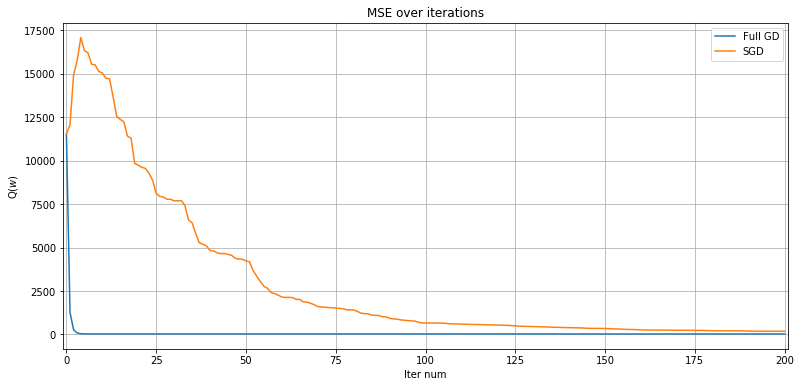

In [18]:
plt.figure(figsize=(13, 6))
plt.plot(range(num_steps+1), residuals_gd, label='Full GD')
plt.plot(range(num_steps+1), residuals_sgd, label='SGD')
plt.title('MSE over iterations')
plt.xlim((-1, num_steps+1))
plt.legend()
plt.xlabel('Iter num')
plt.ylabel(r'Q($w$)')
plt.grid()
plt.show()

Как видно, GD буквально за несколько итераций оказывается вблизи оптимума, в то время как поведение SGD может быть весьма нестабильным. Как правило, для более сложных моделей наблюдаются ещё большие флуктуации в зависимости качества функционала от итерации при использовании стохастических градиентных методов. Путём подбора величины шага можно добиться лучшей скорости сходимости, и существуют методы, адаптивно подбирающие величину шага (AdaGrad, Adam, RMSProp).

## Линейная регрессия из коробки

Наконец, научимся запускать линейную регрессию из коробки (в нашем случае — из scikit-learn). Есть несколько основных объектов, позволяющих обучить линейную регрессию:
* [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) — обычная линейная регрессия с функционалом MSE, при этом оптимизационная задача в этой реализации решается аналитически; 
* [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) — линейная регрессия с L1-регуляризованным функционалом MSE;
* [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) — линейная регрессия с L2-регуляризованным функционалом MSE.

Для использования других функционалов ошибки можно использовать [SGDRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html).

Как мы обсуждали ранее, аналитическое решение задачи линейной регрессии требует бОльших вычислительных ресурсов, нежели градиентные методы решения — проверим это утверждение, обучив LinearRegression и Ridge на одних данных. Помимо времени работы сравним получаемые коэффициенты детерминации $R^2$:

$$R^2 = 1 - \frac{\sum_i (y_i - a(x_i))^2}{\sum_i (y_i - \overline{y}_i)^2}$$

In [22]:
from sklearn.linear_model import LinearRegression, SGDRegressor

In [20]:
n_features = 700
n_objects = 100000
num_steps = 150

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

In [21]:
%%time

lr = LinearRegression()
lr.fit(X,Y)
print('R2: %f' % lr.score(X,Y))

R2: 0.999967
CPU times: user 14.1 s, sys: 1.37 s, total: 15.5 s
Wall time: 5.79 s


In [26]:
max(lr.coef_[0]), min(lr.coef_[0])

(1.983210949805653, -1.9993292567185528)

In [24]:
%%time

lr = SGDRegressor(alpha=0.1)
lr.fit(X,Y)
print('R2: %f' % lr.score(X,Y))

R2: -99493823037422912405504.000000
CPU times: user 1.13 s, sys: 4.59 ms, total: 1.14 s
Wall time: 1.06 s


In [20]:
max(lr.coef_[0]), min(lr.coef_[0])

(1.984032125940023, -1.9993896653905427)

In [23]:
%%time

lr = Ridge(alpha=2, solver='sparse_cg')
lr.fit(X,Y)
print('R2: %f' % lr.score(X,Y))

R2: 0.999968
CPU times: user 2.97 s, sys: 698 ms, total: 3.66 s
Wall time: 1.19 s


In [24]:
max(lr.coef_[0]), min(lr.coef_[0])

(1.9840321145223585, -1.9993896537887348)